# Diversity Evolutionary Algorithm

In [1]:
from functools import partial

import numpy as np

from ariel.body_phenotypes.robogen_lite.decoders.hi_prob_decoding import (
    HighProbabilityDecoder,
)
from ariel.ec.a004 import (
    EA,
    EASettings,
    EAStep,
    Individual,
    Population,
    parent_selection,
)
from ariel.ec.genotypes.nde.nde import NeuralDevelopmentalEncoding
from ariel_experiments.characterize.canonical.core.toolkit import (
    CanonicalToolKit as ctk,
)
from ariel_experiments.characterize.individual import analyze_neighbourhood
from ariel_experiments.characterize.population import (
    get_full_analyzed_population,
    matrix_derive_neighbourhood,
)

#from examples.z_ec_course.A3_template import NUM_OF_MODULES


NUM_OF_MODULES = 20
SEED = 42
RNG = np.random.default_rng(SEED)

# Settings

In [2]:
# Global var
global_fitness_history = []
global_novelty_history = []
old_pop = []
# EA settings
config = EASettings()
config.is_maximisation = False
config.num_of_generations = 30
config.target_population_size = 1000 # this is the starting population

# evaluation settings
similarity_config = ctk.create_similarity_config(
    radius_strategy=ctk.RadiusStrategy.TREE_GLOBAL,
    weighting_mode=ctk.WeightingMode.LINEAR,
    max_tree_radius=3,
    missing_data_mode=ctk.MissingDataMode.TREAT_AS_ZERO,
    softmax_beta=1,
)

In [3]:
def float_creep(
    individual: list[list[float]] | list[list[list[float]]],
    mutation_probability: float,
) -> list[list[float]]:
    # Prep
    ind_arr = np.array(individual)
    shape = ind_arr.shape

    # Generate mutation values
    mutator = RNG.uniform(
        size=shape,
    )

    # Include negative mutations
    sub_mask = RNG.choice(
        [-1, 1],
        size=shape,
    )

    # Determine which positions to mutate
    do_mask = RNG.choice(
        [1, 0],
        size=shape,
        p=[mutation_probability, 1 - mutation_probability],
    )
    mutation_mask = mutator * sub_mask * do_mask
    new_genotype = ind_arr + mutation_mask
    return new_genotype.tolist()

In [4]:
from ariel_experiments.characterize.population import matrix_derive_neighbourhood_cross_pop


def novelty(current_population: Population, old_population: Population) -> float:
    """
    returns the diversity between the last two populations
    """
    score = 0

    analyzed_population_1 = get_full_analyzed_population(
        current_population,
        analyzers=[partial(analyze_neighbourhood, config=similarity_config)],
        derivers=[],
        n_jobs=-1,
        hide_tracker=True,
    )
    analyzed_population_2 = get_full_analyzed_population(
        old_population,
        analyzers=[partial(analyze_neighbourhood, config=similarity_config)],
        derivers=[],
        n_jobs=-1,
        hide_tracker=True,
    )
   
    matrix_result = matrix_derive_neighbourhood_cross_pop(
        (analyzed_population_1.raw,analyzed_population_2.raw),
        config=similarity_config,
        n_jobs=-1,
        hide_tracker=True,
    )
    matrix = matrix_result["similarity_matrix"]["full"]

    for index in range(len(current_population)):

        score += np.sum(matrix[index])
            
    return (score/(len(current_population)*len(old_population)))

In [ ]:
##################################
def record_mean_fitness(population: Population) -> Population:
    new_pop = [ctk.to_graph(ctk.from_string(ind.tags["graph"])) for ind in population if ind.alive == True]
    global old_pop

    mean_fitness = np.mean([ind.fitness for ind in population if hasattr(ind, 'fitness')])

    global_fitness_history.append(mean_fitness)
    novelty_score = novelty(new_pop, old_pop)
    global_novelty_history.append(novelty_score)

#     print(f"Generation {len(global_fitness_history)} - Mean fitness: {mean_fitness:.4f}", 
#           f"Novelty: {novelty_score}")
    old_pop = new_pop
    return population

# EA functions

In [6]:
def make_random_robot(genotype_size: int = 64) -> Individual:
    """
    Produces an robot with only its genotype.

    genotype_size is standard 64
    """
    ind = Individual()
    ind.genotype = [
        RNG.random(genotype_size).tolist(),
        RNG.random(genotype_size).tolist(),
        RNG.random(genotype_size).tolist(),
    ]
    nde = NeuralDevelopmentalEncoding(number_of_modules=NUM_OF_MODULES)
    hpd = HighProbabilityDecoder(num_modules=NUM_OF_MODULES)

    matrixes = nde.forward(np.array(ind.genotype))
    ind.tags["graph"] = ctk.to_string(ctk.from_graph(hpd.probability_matrices_to_graph(
        matrixes[0], matrixes[1], matrixes[2]
    )))
    return evaluation_diversity([ind])[0]


def crossover(population: Population) -> Population:
    """Does uniform crossover."""
    mask = RNG.random(size=np.array(population[0].genotype).shape) < 0.5
    children = []
    for parent in population:
        child = Individual()
        parent2 = RNG.choice(population)
        child.genotype = np.where(
            mask, np.array(parent.genotype), np.array(parent2.genotype)
        ).tolist()
        children.append(child)
    population.extend(children)
    return population


def mutation(population: Population) -> Population:
    """Randomly changes genotype values by a random amount."""
    mutation_rate = 0.01  # mutation rate to be changed
    for ind in population:
        if ind.tags.get("mut", False):
            genes = ind.genotype
            mutated = [
                float_creep(
                    individual=genes[0],
                    mutation_probability=mutation_rate,
                ),
                float_creep(
                    individual=genes[1],
                    mutation_probability=mutation_rate,
                ),
                float_creep(
                    individual=genes[2],
                    mutation_probability=mutation_rate,
                ),
            ]
            ind.genotype = mutated
            ind.requires_eval = True
    return population


def evaluation_diversity(population: Population) -> Population:
    """Produces an individual that is evaluated."""
    graph_population = [None] * len(population)

    # for initial population creation
    if len(population) <= 1:
        population[0].fitness = 0.0
        population[0].requires_eval = True
        return population

    for idx, ind in enumerate(population):
        if "graph" in ind.tags:
            graph_population[idx] = ctk.to_graph(ctk.from_string(ind.tags["graph"]))
        else:
            nde = NeuralDevelopmentalEncoding(number_of_modules=NUM_OF_MODULES)
            hpd = HighProbabilityDecoder(num_modules=NUM_OF_MODULES)

            matrixes = nde.forward(np.array(ind.genotype))
            ind_graph = hpd.probability_matrices_to_graph(
                matrixes[0], matrixes[1], matrixes[2]
            )
            ind.tags["graph"] = ctk.to_string(ctk.from_graph(ind_graph))
            graph_population[idx] = ind_graph

    analyzed_population = get_full_analyzed_population(
        graph_population,
        analyzers=[partial(analyze_neighbourhood, config=similarity_config)],
        derivers=[],
        n_jobs=-1,
        hide_tracker=True,
    )
    matrix_result = matrix_derive_neighbourhood(
        analyzed_population.raw,
        config=similarity_config,
        symmetric=True,
        n_jobs=-1,
        hide_tracker=True,
    )
    matrix = matrix_result["similarity_matrix"]["full"]

    for index, ind in enumerate(population):
        if ind.requires_eval:
            ind.requires_eval = False  # diversity gets evaluated each time

            fitness = np.sum(matrix[index])
            population[index].fitness = (float(fitness) - 1) / len(population)

    return population


def survivor_selection(population: Population) -> Population:
    
    RNG.shuffle(population)
    current_pop_size = len(population)

    for idx in range(0, len(population) - 1, 2):
        ind_i = population[idx]
        ind_j = population[idx + 1]

        if config.is_maximisation:
            if ind_i.fitness < ind_j.fitness:
                ind_i.alive = False
            else:
                ind_j.alive = False
        else:
            if ind_i.fitness > ind_j.fitness:
                ind_i.alive = False
            else:
                ind_j.alive = False
        current_pop_size -= 1
        if current_pop_size <= config.target_population_size:
            break

    return population


# run


In [7]:
ops = [
    EAStep("parent_selection", parent_selection),
    EAStep("crossover", crossover),
    EAStep("mutation", mutation),
    EAStep("evaluation", evaluation_diversity),
    EAStep("survivor_selection", survivor_selection),
    EAStep("record_fitness", record_mean_fitness), 
]

# population = [ make_random_robot(genotype_size) for _ in range(10)] # generating genotypes
# robot = nde.forward(np.array(population[0].genotype))
# evaluation_diversity(population=population)

In [8]:
# hyperparameters
population_size = 10
num_of_generations = 5
genotype_size = 64  # 64 is standard in the NDE


# population
population_list = [
    make_random_robot(genotype_size) for _ in range(config.target_population_size)
]  # generating genotypes
old_pop = [ctk.to_graph(ctk.from_string(ind.tags["graph"])) for ind in population_list]

In [9]:
# I USED THIS TO VISUALIZE

# # place in cell above:
# # tracker = 0


# # place in cell below
# nde = NeuralDevelopmentalEncoding(number_of_modules=NUM_OF_MODULES)
# hpd = HighProbabilityDecoder(num_modules=NUM_OF_MODULES)
# matrixes = nde.forward(np.array(population_list[tracker].genotype))
# ind_graph = hpd.probability_matrices_to_graph(
#     matrixes[0], matrixes[1], matrixes[2]
# )

# view(ind_graph)
# tracker + (tracker + 1) % len(population_list)

In [10]:
ea = EA(
    population_list,
    operations=ops,
    num_of_generations=config.num_of_generations
)

ea.run()

[11:45:33] Database file exists at                                                                       ]8;id=852793;file://C:\Users\savio\Documents\git_stuff\ariel-zoo\src\ariel\ec\a004.py\a004.py]8;;\:]8;id=983642;file://C:\Users\savio\Documents\git_stuff\ariel-zoo\src\ariel\ec\a004.py#98\98]8;;\
           c:\Users\savio\Documents\git_stuff\ariel-zoo\zoo\__data__\database.db!                                  
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Output()

Generation 1 - Mean fitness: 0.0860 Novelty: 0.08245164155960083

Generation 2 - Mean fitness: 0.0828 Novelty: 0.07717790454626083

Generation 3 - Mean fitness: 0.0805 Novelty: 0.07431191205978394

Generation 4 - Mean fitness: 0.0793 Novelty: 0.07254982739686966

Generation 5 - Mean fitness: 0.0781 Novelty: 0.07138202339410782

Generation 6 - Mean fitness: 0.0774 Novelty: 0.07068786025047302

Generation 7 - Mean fitness: 0.0768 Novelty: 0.07008640468120575

Generation 8 - Mean fitness: 0.0765 Novelty: 0.06959715485572815

Generation 9 - Mean fitness: 0.0763 Novelty: 0.06933604180812836

Generation 10 - Mean fitness: 0.0762 Novelty: 0.06909552961587906

Generation 11 - Mean fitness: 0.0759 Novelty: 0.06877535581588745

Generation 12 - Mean fitness: 0.0758 Novelty: 0.06849660724401474

Generation 13 - Mean fitness: 0.0755 Novelty: 0.06833966821432114

Generation 14 - Mean fitness: 0.0755 Novelty: 0.06814801692962646

Generation 15 - Mean fitness: 0.0754 Novelty: 0.06825493276119232

Generation 16 - Mean fitness: 0.0756 Novelty: 0.06822890788316727

Generation 17 - Mean fitness: 0.0751 Novelty: 0.06787550449371338

Generation 18 - Mean fitness: 0.0752 Novelty: 0.06773888319730759

Generation 19 - Mean fitness: 0.0751 Novelty: 0.06760545819997787

Generation 20 - Mean fitness: 0.0749 Novelty: 0.06736123561859131

Generation 21 - Mean fitness: 0.0745 Novelty: 0.06727539002895355

Generation 22 - Mean fitness: 0.0745 Novelty: 0.0671948492527008

Generation 23 - Mean fitness: 0.0745 Novelty: 0.06692715734243393

Generation 24 - Mean fitness: 0.0744 Novelty: 0.06689586490392685

Generation 25 - Mean fitness: 0.0745 Novelty: 0.06688521057367325

Generation 26 - Mean fitness: 0.0743 Novelty: 0.06665632128715515

Generation 27 - Mean fitness: 0.0743 Novelty: 0.06657359004020691

Generation 28 - Mean fitness: 0.0744 Novelty: 0.06685531139373779

Generation 29 - Mean fitness: 0.0747 Novelty: 0.0670815259218216

Generation 30 - Mean fitness: 0.0748 Novelty: 0.06713134795427322

─────────────────────────────────────────────── EA Finished Running ───────────────────────────────────────────────

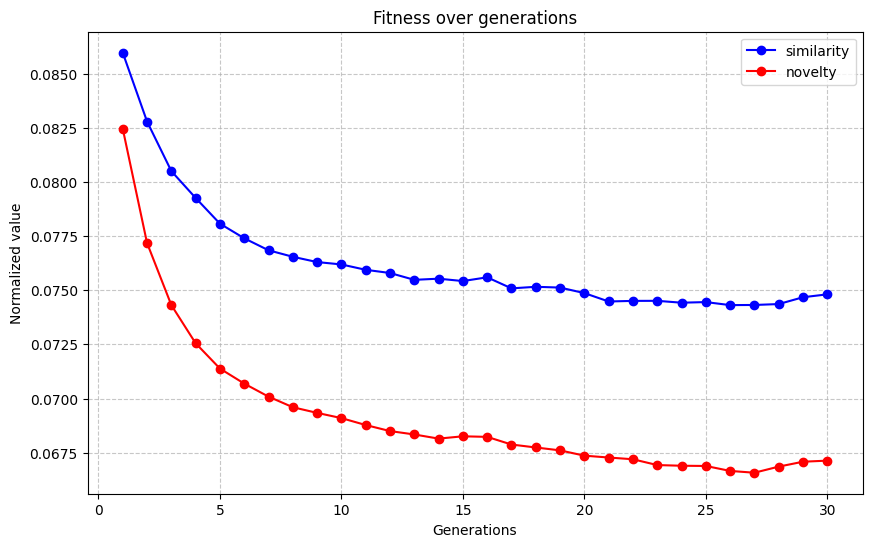

In [15]:
############################
import matplotlib.pyplot as plt

def plot_fitness_history():
    if not global_fitness_history:
        print("No fitness recorded for plotting")
        return

    generations = range(1, len(global_fitness_history) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(
        generations, 
        global_fitness_history, 
        marker='o', 
        linestyle='-', 
        color='blue',
        label="similarity"
    )
    plt.plot(
        generations, 
        global_novelty_history, 
        marker='o', 
        linestyle='-', 
        color='red',
        label="novelty"
    )
    plt.legend(loc="upper right")
    plt.title('Fitness over generations')
    plt.xlabel('Generations')
    plt.ylabel('Normalized value') 
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

plot_fitness_history()